<a href="https://colab.research.google.com/github/cedro3/CodeFormer/blob/master/CodeFormer%2BDeOldify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title **セットアップ**

# --- CodeFormer set up ---
# Clone CodeFormer and enter the CodeFormer folder
%cd /content
!rm -rf CodeFormer
!git clone https://github.com/cedro3/CodeFormer.git
%cd CodeFormer

# Set up the environment
# Install python dependencies
!pip install -r requirements.txt
# Install basicsr
!python basicsr/setup.py develop

# Download the pre-trained model
!python scripts/download_pretrained_models.py facelib
!python scripts/download_pretrained_models.py CodeFormer

# Define function
from function import *

# make dir
! mkdir download


# --- DeOldify setup ---
# Clone DeOldify
%cd /content
!rm -rf DeOldify
!git clone https://github.com/jantic/DeOldify.git
%cd DeOldify
 
#NOTE:  This must be the first call in order to work properly!
from deoldify import device
from deoldify.device_id import DeviceId
 
#choices:  CPU, GPU0...GPU7
device.set(device=DeviceId.GPU0)
import torch
if not torch.cuda.is_available():
    print('GPU not available.')
 
# install library
! pip install -r requirements-colab.txt
 
# import library
import fastai
from deoldify.visualize import *
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*?Your .*? set is empty.*?")
 
# download models
! mkdir 'models'
! wget https://data.deepai.org/deoldify/ColorizeVideo_gen.pth -O ./models/ColorizeVideo_gen.pth
 
# download watermark
#! wget https://media.githubusercontent.com/media/jantic/DeOldify/master/resource_images/watermark.png -O ./resource_images/watermark.png
 
# load model
colorizer = get_video_colorizer()

# make dir
! mkdir video
! mkdir video/source

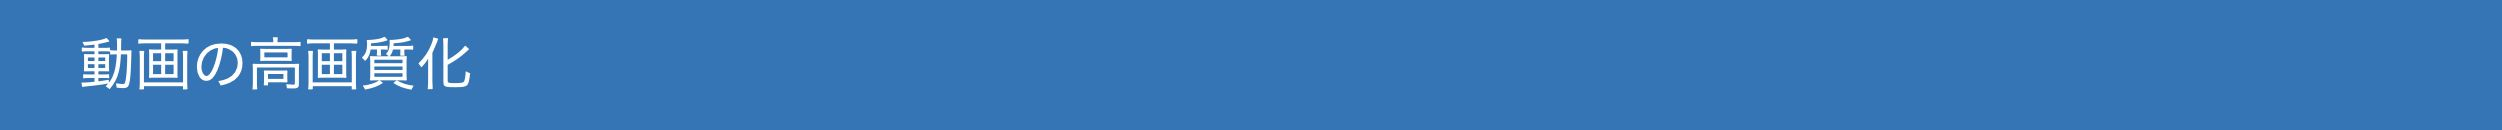

In [ ]:
#@title **動画の読み込み**

#@markdown ■movie フォルダに音声付き動画（mp4）をアップロードして下さい\
#@markdown ■60秒以内（30fpsの場合）として下さい
%cd /content/CodeFormer

# 設定
video = 'mari.mp4' #@param {type:"string"}
video_file = 'movie/'+video
image_dir='inputs/frame/'
image_file='%s.png'

# video_2_images
reset_folder('inputs/frame')
fps, i, interval = video_2_images(video_file, image_dir, image_file)

# スタートフレーム表示
from google.colab.patches import cv2_imshow
img = cv2.imread('inputs/frame/000000.png')
cv2_imshow(img)

# サイズ取得
height, width = img.shape[:2]
screen_size = str(width)+'x'+str(height)

# パラメータ表示
print('screen size = ', screen_size)
print('fps = ', fps)
print('frames = ', i)
print('interval = ', interval)

In [ ]:
from types import FrameType
#@title **動画の高画質化（CodeFormer）**
#@markdown　■処理時間は1秒(30fps）の動画で１分程度かかります

# 設定
input_folder = 'inputs/frame'
w = 0.7 #@param {type:"slider", min:0.1, max:0.9, step:0.1}
reset_folder('results/frame_'+str(w))

# フレームの高画質化
! python inference_codeformer.py --w $w\
                                  --test_path $input_folder\
                                  --bg_upsampler realesrgan\
                                  --face_upsample

# ログ・クリア
clear_output()

# 動画の作成
print('making movie...')
fps_r = fps/interval
file_path = 'results/frame_'+str(w)+'/final_results/%06d.png'
! ffmpeg -y -r $fps_r -i $file_path -s $screen_size -vcodec libx264 -pix_fmt yuv420p -loglevel error out.mp4

# 音声の抽出・付加
print('preparation for sound...')
! ffmpeg -y -i $video_file -loglevel error sound.mp3
! ffmpeg -y -i out.mp4 -i sound.mp3 -loglevel error output.mp4

# 動画の再生
print('waiting for play movie...')
display_mp4('output.mp4')

In [ ]:
#@title **動画のダウンロード**
#@markdown ■google chrome 専用
from google.colab import files
import shutil

dst_filepath = 'download/'+os.path.splitext(video)[0]+'_s.mp4'
shutil.copy('output.mp4', dst_filepath)
files.download(dst_filepath)

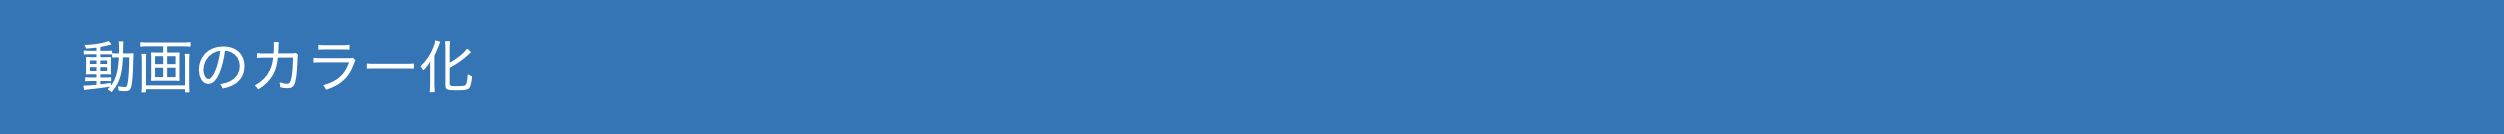

In [ ]:
#@title **動画をDeOldifyへコピー**
shutil.copy('/content/CodeFormer/output.mp4', '/content/DeOldify/video/source/movie.mp4')


In [ ]:
#@title **動画のカラー化（DeOldify）**
%cd /content/DeOldify
video ='movie.mp4' 
render_factor =21  

video_path = colorizer.colorize_from_file_name(video,\
                                                      render_factor,\
                                                      watermarked=False)
show_video_in_notebook('video/result/'+video)

In [ ]:
#@title **動画のダウンロード**
#@markdown ■google chrome 専用
from google.colab import files
files.download('video/result/movie.mp4')